# ART - Adversarial Patch - PyTorch - YOLO

In [1]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from tqdm import tqdm

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import AdversarialPatchPyTorch


import cv2
import matplotlib
import matplotlib.pyplot as plt


plt.style.use('ggplot')
matplotlib.use( 'tkagg' )
%matplotlib inline

# Helper functions and Labels

In [2]:
COCO_INSTANCE_CATEGORY_NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions_["labels"])]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 1
    text_th = 3
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    # plt.show()



# Attack Settings

In [3]:
rotation_max=0.0
scale_min=0.1
scale_max=0.3
distortion_scale_max=0.0
learning_rate=1.99
max_iter=200
batch_size=16
patch_shape=(3, 640, 640)
patch_location=None
patch_type="circle"
optimizer="pgd"

# Model definition

Yolov3 and Yolov5 supported. 

- To use Yolov3, run ```pip install pytorchyolo```
- To use Yolov5, run ```pip install yolov5```

Note: If pytorchyolo throws an error in pytorchyolo/utils/loss.py, add before line 174 in that file, the following:
```gain = gain.to(torch.int64)```

In [4]:
MODEL = 'yolov3' # OR yolov5


if MODEL == 'yolov3':

    from pytorchyolo.utils.loss import compute_loss
    from pytorchyolo.models import load_model

    class Yolo(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, x, targets=None):
            if self.training:
                outputs = self.model(x)
                loss, loss_components = compute_loss(outputs, targets, self.model)
                loss_components_dict = {"loss_total": loss}
                loss_components_dict['loss_box'] = loss_components[0]
                loss_components_dict['loss_obj'] = loss_components[1]
                loss_components_dict['loss_cls'] = loss_components[2]
                return loss_components_dict
            else:
                tmp = self.model(x)
                return tmp

    model_path = "./../../yolov3.cfg"
    weights_path = "./../../yolov3.weights"
    model = load_model(model_path=model_path, weights_path=weights_path)
            
    model = Yolo(model)

    detector = PyTorchYolo(model=model,
                        device_type='cpu',
                        input_shape=(3, 640, 640),
                        clip_values=(0, 255), 
                        attack_losses=("loss_total", "loss_cls",
                                        "loss_box",
                                        "loss_obj"))

elif MODEL == 'yolov5':

    import yolov5
    from yolov5.utils.loss import ComputeLoss

    class Yolo(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            self.model.hyp = {'box': 0.05,
                            'obj': 1.0,
                            'cls': 0.5,
                            'anchor_t': 4.0,
                            'cls_pw': 1.0,
                            'obj_pw': 1.0,
                            'fl_gamma': 0.0
                            }
            self.compute_loss = ComputeLoss(self.model.model.model)

        def forward(self, x, targets=None):
            if self.training:
                outputs = self.model.model.model(x)
                loss, loss_items = self.compute_loss(outputs, targets)
                loss_components_dict = {"loss_total": loss}
                loss_components_dict['loss_box'] = loss_items[0]
                loss_components_dict['loss_obj'] = loss_items[1]
                loss_components_dict['loss_cls'] = loss_items[2]
                return loss_components_dict
            else:
                return self.model(x)

    model = yolov5.load('yolov5s.pt')
    
    model = Yolo(model)

    detector = PyTorchYolo(model=model,
                        device_type='cpu',
                        input_shape=(3, 640, 640),
                        clip_values=(0, 255), 
                        attack_losses=("loss_total", "loss_cls",
                                        "loss_box",
                                        "loss_obj"))

# Example images

In [5]:
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, 640, 640)

transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE[1], interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(INPUT_SHAPE[1]),
        transforms.ToTensor()
    ])

urls = ['http://images.cocodataset.org/val2017/000000039769.jpg',
'http://images.cocodataset.org/val2017/000000397133.jpg',
'http://images.cocodataset.org/val2017/000000037777.jpg',
'http://images.cocodataset.org/val2017/000000454661.jpg',
'http://images.cocodataset.org/val2017/000000094852.jpg']
coco_images = []
for url in urls:
    im = Image.open(requests.get(url, stream=True).raw)
    im = transform(im).numpy()
    coco_images.append(im)
coco_images = np.array(coco_images)*255

## Detector Predictions on Benign Images

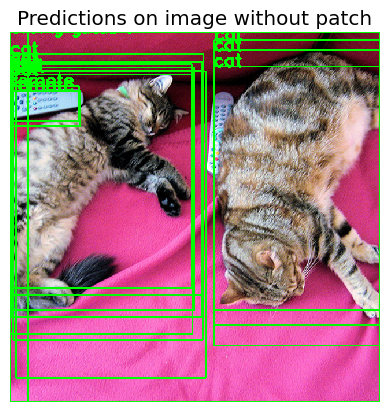

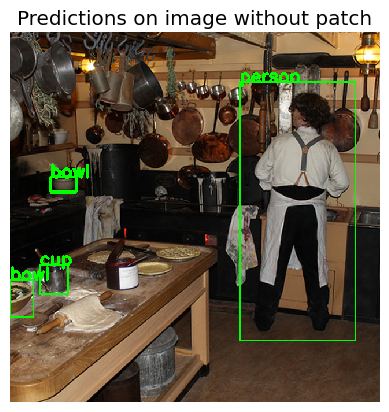

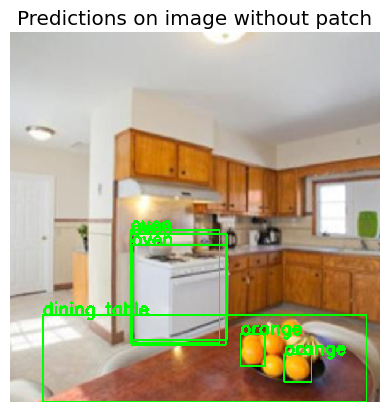

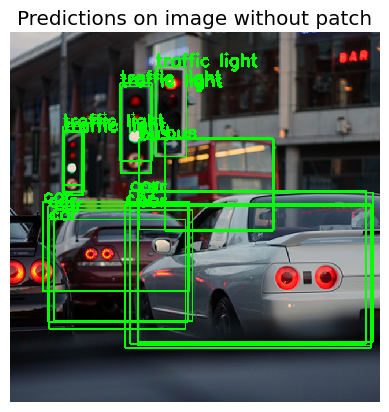

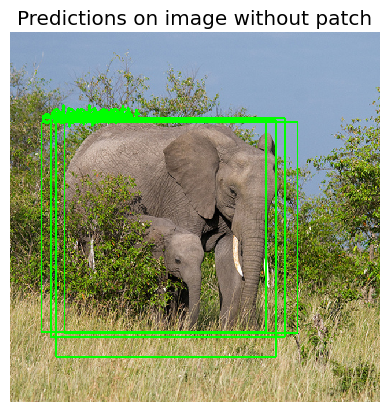

In [6]:
%matplotlib inline
dets = detector.predict(coco_images) 
for i in range(len(dets)):
    preds_orig = extract_predictions(dets[i], 0.8)
    plot_image_with_boxes(img=coco_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Predictions on image without patch")

## Adversarial Patch Generation
We'll use the last image of an elephant as a target for our adversarial patch. A successful patch will therefore cause the detector to identify an elephant in the patched images. 

In [7]:
def filter_boxes(predictions, conf_thresh):
    dictionary = {}

    boxes_list = []
    scores_list = []
    labels_list = []

    for i in range(len(predictions[0]["boxes"])):
        score = predictions[0]["scores"][i]
        if score >= conf_thresh:
            boxes_list.append(predictions[0]["boxes"][i])
            scores_list.append(predictions[0]["scores"][[i]])
            labels_list.append(predictions[0]["labels"][[i]])

    dictionary["boxes"] = np.vstack(boxes_list)
    dictionary["scores"] = np.hstack(scores_list)
    dictionary["labels"] = np.hstack(labels_list)

    y = [dictionary]

    return y

y = [filter_boxes([t], 0.8)[0] for t in dets]

Adversarial Patch PyTorch:   0%|          | 0/1000 [00:00<?, ?it/s]

/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/transforms/functional.py:675: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


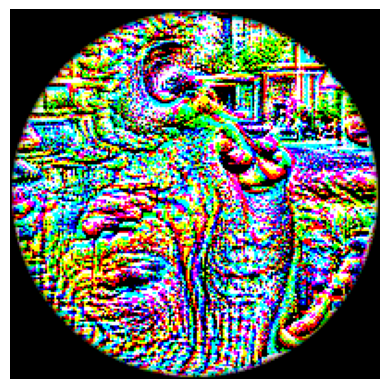

In [9]:

ap = AdversarialPatchPyTorch(estimator=detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=1000, batch_size=batch_size,
                      patch_shape=(3, 200, 200), patch_type=patch_type, verbose=True, targeted=True)

patch, patch_mask = ap.generate(x=coco_images[:-1], y=[y[-1] for i in range(len(coco_images[:-1]))])

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0).astype(np.uint8))
plt.show()

## Predictions on patched images

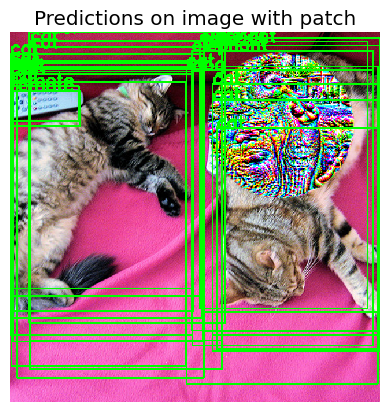

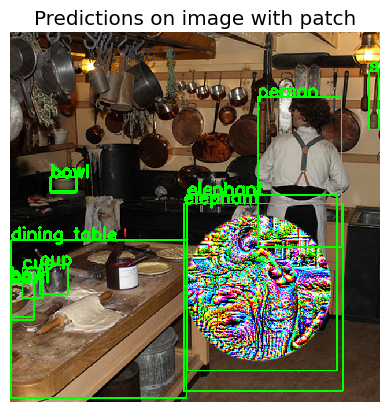

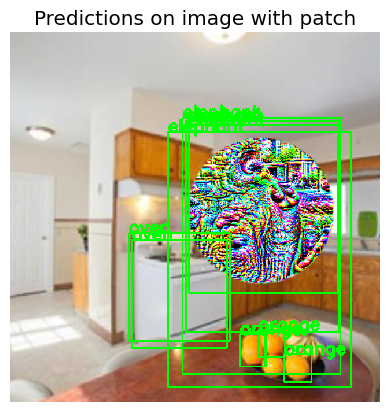

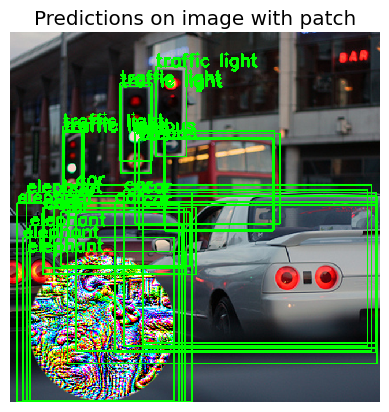

In [15]:
patched_images = ap.apply_patch(coco_images[:-1], scale=0.4)
dets = detector.predict(patched_images)
for i in range(len(dets)):
    preds_orig = extract_predictions(dets[i], 0.5)
    plot_image_with_boxes(img=patched_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0],
                           title="Predictions on image with patch")

## RobustDPatch

100%|██████████| 100/100 [08:34<00:00,  5.15s/it]


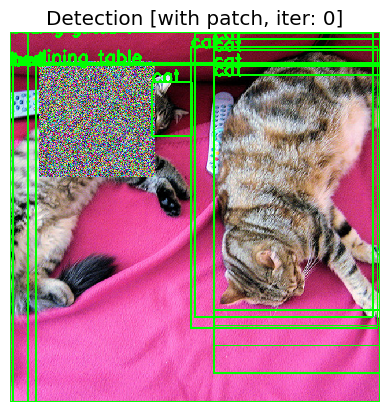

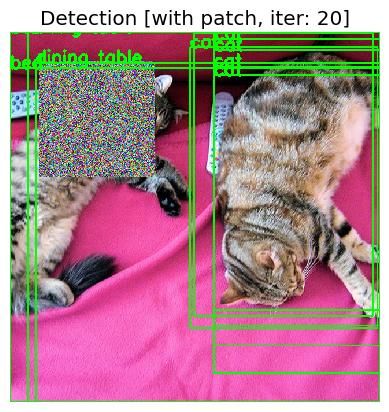

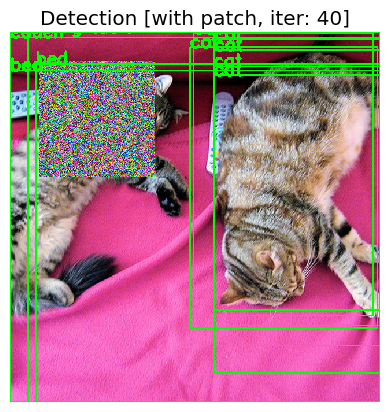

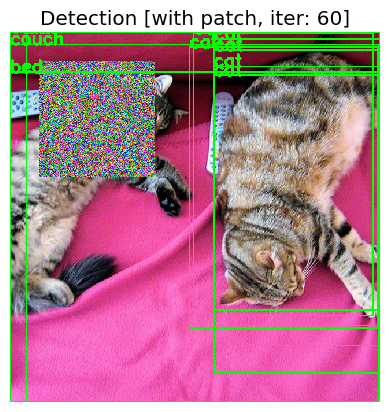

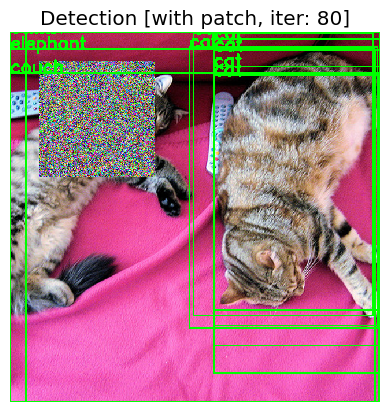

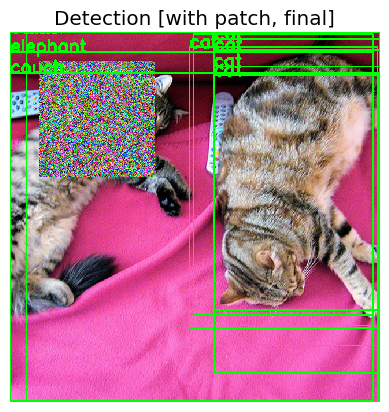

In [24]:
from art.attacks.evasion import RobustDPatch

x = coco_images[:-1]
y = [y[-1] for i in range(len(coco_images[:-1]))]

attack = RobustDPatch(
    detector,
    patch_shape=(3, 200, 200),
    patch_location=(50, 50),
    crop_range=[0,0],
    brightness_range=[1.0, 1.0],
    rotation_weights=[1, 0, 0, 0],
    sample_size=1,
    learning_rate=1.99,
    max_iter=1,
    batch_size=1,
    verbose=False,
    targeted=True
)

loss_history = []
for i in tqdm(range(100)):
    patch = attack.generate(x, y)
    patched_images = attack.apply_patch(x)

    loss_components, _ = detector._get_losses(patched_images, dets[:-1])
    losses = {}
    for loss in loss_components.keys():
        if 'loss' in loss:
            losses[loss] = loss_components[loss].item()
    loss_history.append(losses)

    if i%20==0:
        _y = detector.predict(patched_images)
        preds = extract_predictions(_y[0], 0.5)
        im = (patched_images[0].transpose(1,2,0)).astype(np.uint8)
        plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, iter: {i}]")

_y = detector.predict(patched_images)
preds = extract_predictions(_y[0], 0.5)
im = (patched_images[0].transpose(1,2,0)).astype(np.uint8)
plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, final]")  

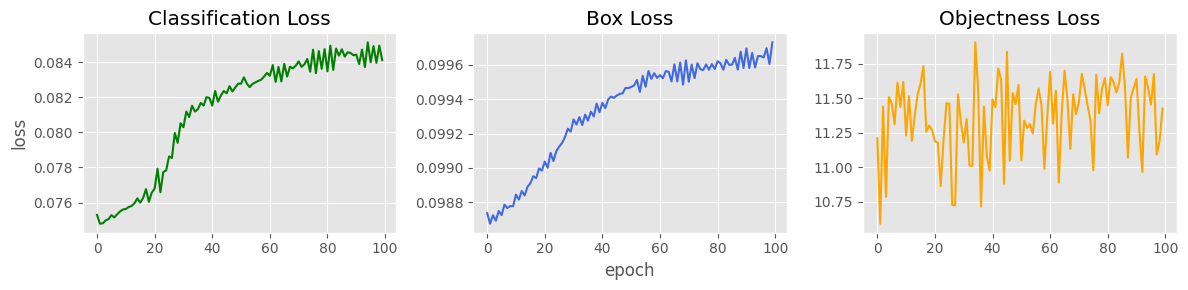

In [25]:
%matplotlib inline
losses = pd.DataFrame(loss_history)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
losses.loss_cls.plot(ylabel='loss', ax = axes[0], subplots=True, color='g')
losses.loss_box.plot(xlabel='epoch', ax = axes[1],subplots=True, color='royalblue')
losses.loss_obj.plot( ax = axes[2],subplots=True, color='orange')


axes[0].set_title('Classification Loss')
axes[1].set_title('Box Loss')
axes[2].set_title('Objectness Loss')
fig.tight_layout()